# Does discounting moderate the rate of BMI gain with age?
This notebook tests the hypothesis that log discount rates moderate the rate at which we gain BMI with age. The basic approach is one of Bayesian moderation analysis. Before we get to the Bayesian part, let's just consider the model.

## The moderation model approach

First, we will consider a 'full' moderation analysis:

$$
BMI = \beta_0 + (slope \cdot age) + (\beta_2 \cdot logk)
$$

where

$$
slope = \beta_1 + \beta_3 \cdot logk
$$

so

$$
BMI = \beta_0 + ((\beta_1 + \beta_3 \cdot logk) \cdot age) + (\beta_2 \cdot logk)\\
BMI = \beta_0 + (\beta_1 \cdot age) + (\beta_2 \cdot logk) + (\beta_3 \cdot age \cdot logk)
$$

Where:
- $\beta_0$ is the intercept
- $\beta_1$ is the rate at which BMI increases per year of age. If $\beta_1 \neq 0$ then we have a main effect of age. 
- $\beta_2$ is the way in which BMI increases as `logk` increases. If $\beta_2 \neq 0$ then we have a main effect of discount rate. 
- $\beta_3$ is the coefficient for the moderation term $age \cdot logk$. If $\beta_3 \neq 0$ then we have a moderation effect.

In [1]:
# Install Black autoformatter with: pip install nb-black
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [4]:
from bayesian_moderation import BayesianModeration

figsize = (8, 12)

# define different prior parameters for the BMI and WHtR outcome measures

BMI_prior = {
    "β0μ": 12,
    "β0σ": 20,
    "β1μ": 0,
    "β1σ": 20,
    "β2μ": 0,
    "β2σ": 20,
    "β3μ": 0,
    "β3σ": 20,
    "σ": 1,
}

WHtR_prior = {
    "β0μ": 0.5,
    "β0σ": 5,
    "β1μ": 0,
    "β1σ": 20,
    "β2μ": 0,
    "β2σ": 20,
    "β3μ": 0,
    "β3σ": 20,
    "σ": 1,
}

# define sampling options
SEED = 123
n_samples = 5_000
sample_options = {
    "tune": 2_000,
    "draws": n_samples,
    "chains": 6,
    "cores": 6,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

## Load and process Study 2 data

In [5]:
data = pd.read_csv("../data/04 final data/study2_final_data.csv")

# remove any rows full of missing values
data = data.dropna()

# # convert age from units of years into decades
# data["age"] = data["age"] / 10
data.head()

URN  age     sex  height_meters  weight_kg  \
0   542031-542022-53955464   21  female           1.60       59.0   
4   542031-542022-53956174   23    male           1.75       77.0   
10  542031-542022-53956911   22    male           1.75       90.0   
12  542031-542022-53956904   38    male           1.70       83.0   
14  542031-542022-53957686   22  female           1.57       78.0   

    waist_meters     BMI   WHtR  subjective_hunger  logk_fcq  logk_wcq  
0           0.71  23.047  0.444              2.933 -1.755149 -2.182604  
4           0.76  25.143  0.434              3.600 -1.355593 -1.888877  
10          0.86  29.388  0.491              4.200 -1.064551 -3.360791  
12          0.86  28.720  0.506              2.867 -1.581371 -4.913089  
14          0.78  31.644  0.497              4.333 -0.849653 -1.490817

(array([ 1.,  3.,  0.,  2.,  1.,  6.,  3.,  4.,  4., 15., 11., 12.,  5.,
        15.,  9., 15., 26., 14.,  5.,  3.]),
 array([-3.21433784, -3.07924584, -2.94415383, -2.80906183, -2.67396982,
        -2.53887782, -2.40378582, -2.26869381, -2.13360181, -1.99850981,
        -1.8634178 , -1.7283258 , -1.59323379, -1.45814179, -1.32304979,
        -1.18795778, -1.05286578, -0.91777378, -0.78268177, -0.64758977,
        -0.51249776]),
 <a list of 20 Patch objects>)

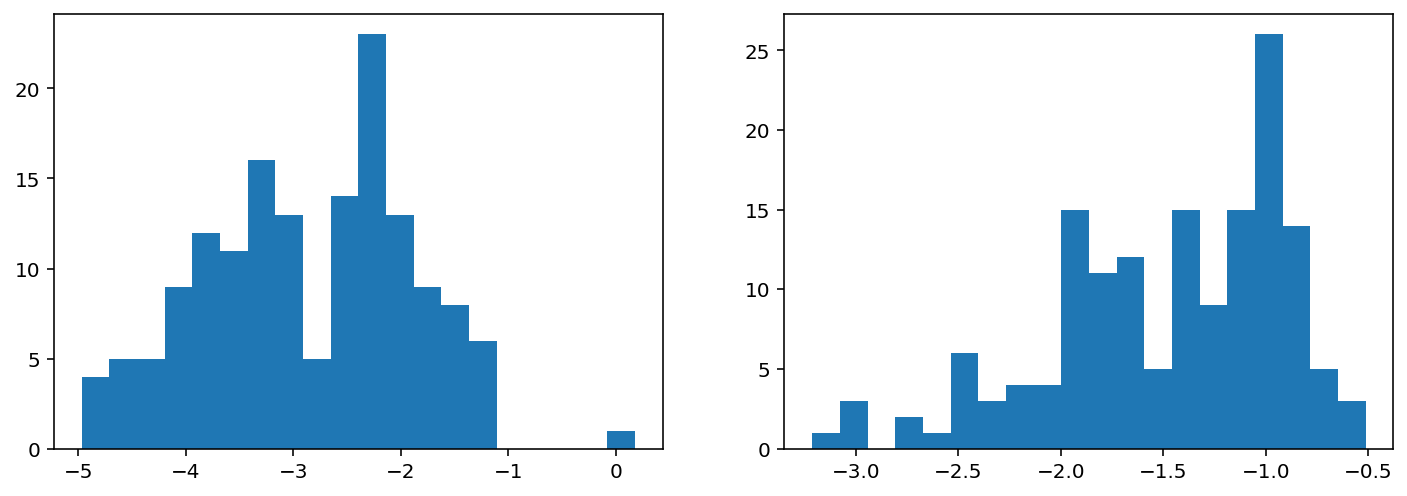

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(data.logk_wcq.values, 20)
ax[1].hist(data.logk_fcq.values, 20)

# Discounting of money

## Analysis 1: `bmi ~ age + logk_weight + age:logk_weight`

In [7]:
bmi_age_weight = BayesianModeration(
    y=data.BMI.values,
    x=data.age.values,
    m=data.logk_wcq.values,
    xlabel=r"Age [years]",
    ylabel="BMI [$kg/m^2$]",
    mlabel=r"$\ln(k_{weight})$",
    prior=BMI_prior,
    sample_options=sample_options,
)

model = bmi_age_weight.model
trace = bmi_age_weight.trace

Prior parameters are:
{'β0μ': 12, 'β0σ': 20, 'β1μ': 0, 'β1σ': 20, 'β2μ': 0, 'β2σ': 20, 'β3μ': 0, 'β3σ': 20, 'σ': 1}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [σ, β3, β2, β1, β0]
Sampling 6 chains, 0 divergences: 100%|██████████| 42000/42000 [00:47<00:00, 880.42draws/s] 
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc8c106850>,
      dtype=object)

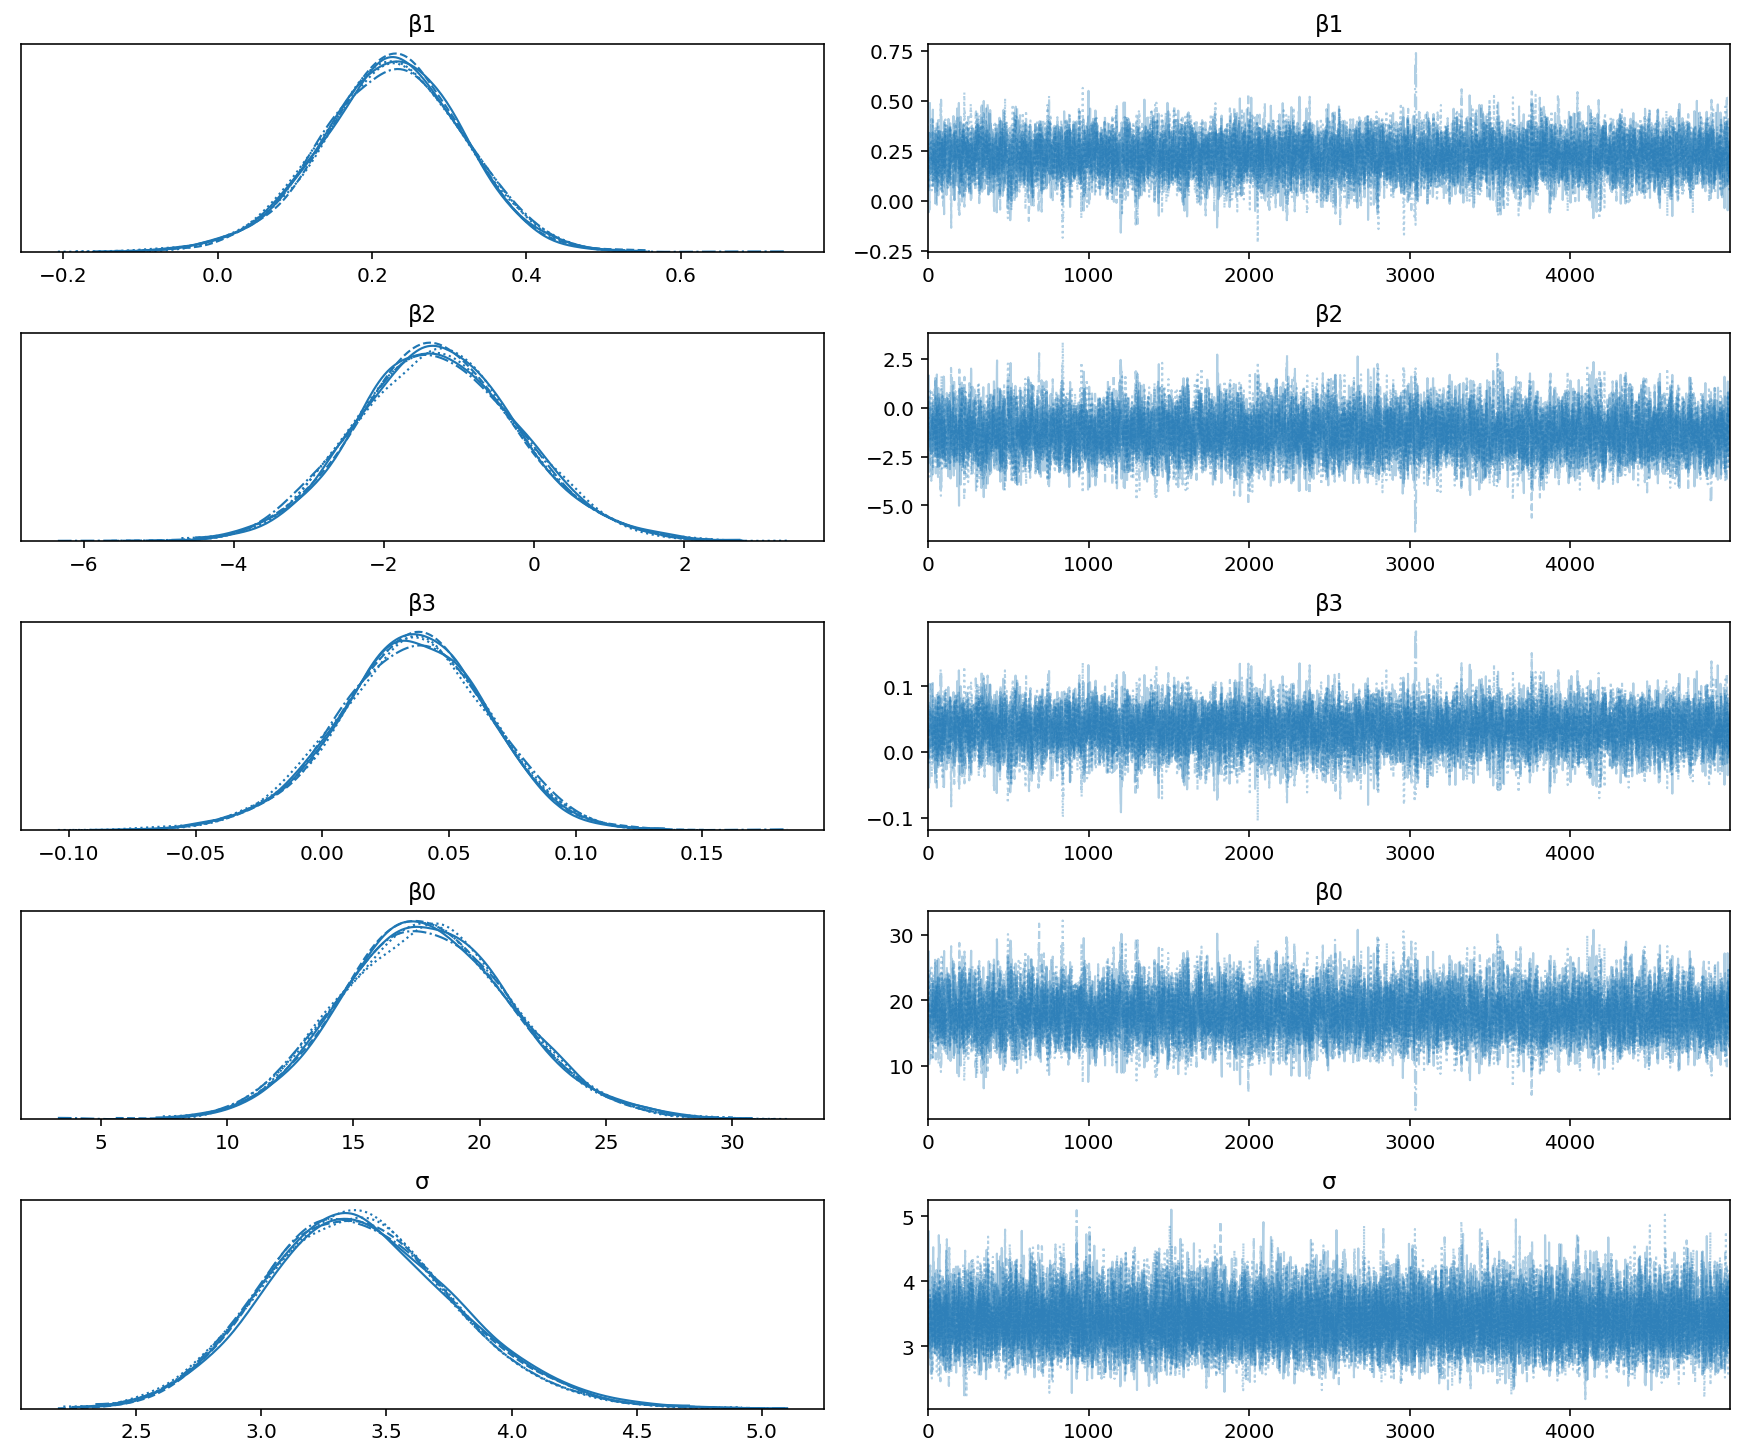

In [8]:
pm.traceplot(trace)

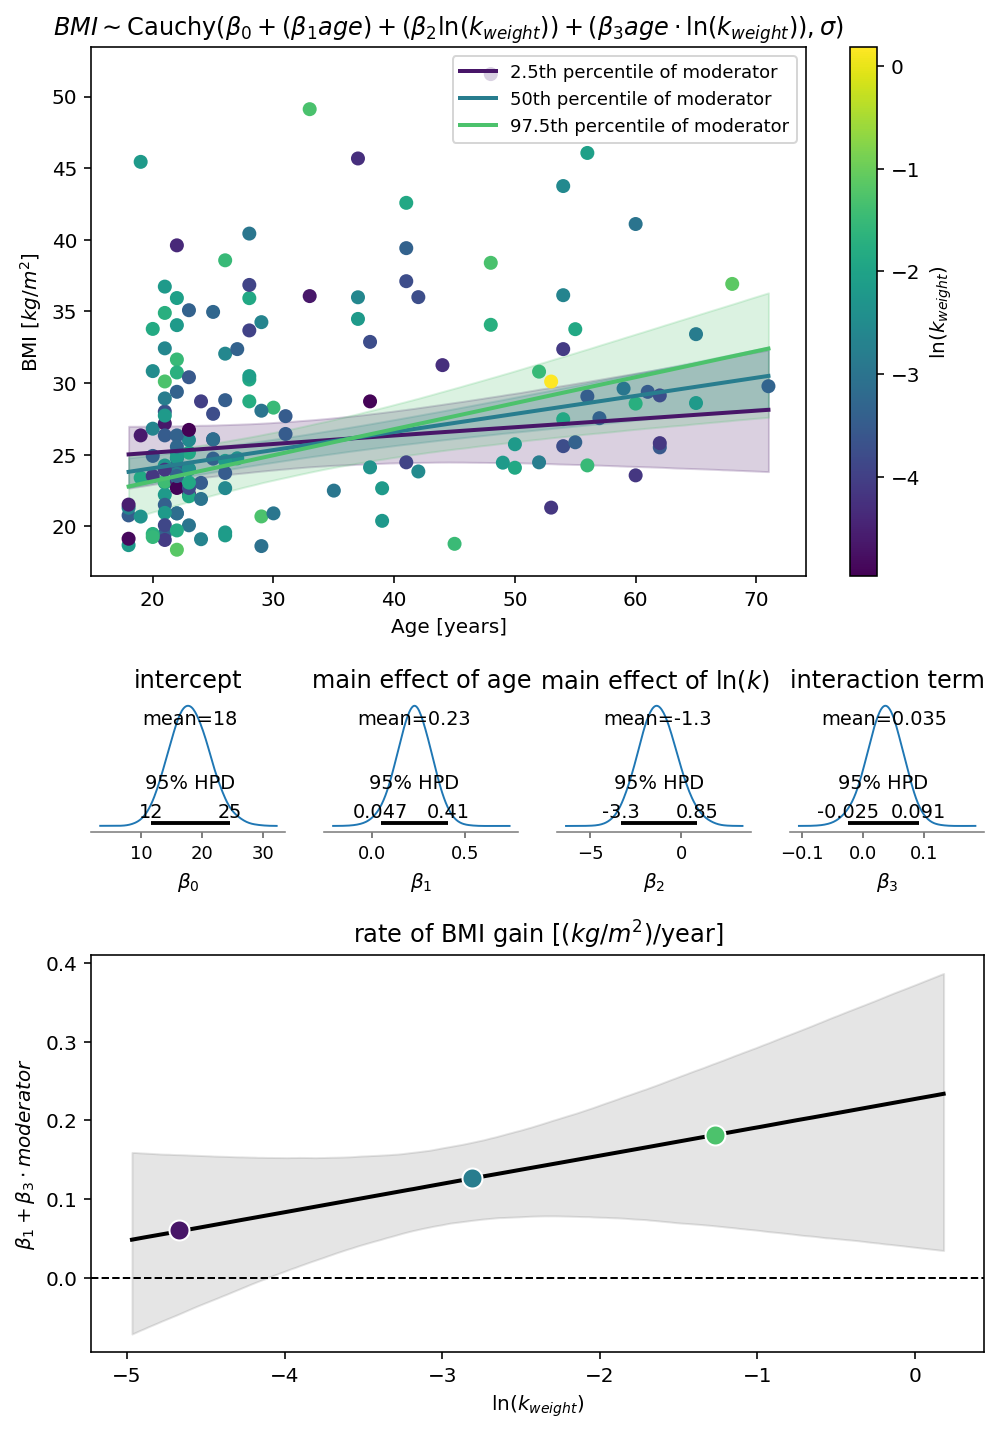

In [9]:
# moderation_multiplier = 10 means the rate of BMI gain is per decade, rather than per year
ax1, ax2, axb0, axb1, axb2, axb3 = bmi_age_weight.plot_multipanel(
    figsize=figsize, moderation_multiplier=1,
)

# modifications to plot

ax1.set(
    title=r"$BMI \sim \mathrm{Cauchy}(\beta_0 + (\beta_1 age) + (\beta_2 \ln(k_{weight})) + (\beta_3 age \cdot \ln(k_{weight})), \sigma)$"
)

ax2.set(title="rate of BMI gain [$(kg/m^2)$/year]")

plt.savefig("study2 bmi~age*weight.pdf", bbox_inches="tight")
plt.savefig("study2 bmi~age*weight.png", bbox_inches="tight", dpi=300)

## Analysis 2: `WHtR ~ age + logk_weight + age:logk_weight`

In [10]:
whtr_age_weight = BayesianModeration(
    y=data.WHtR.values,
    x=data.age.values,
    m=data.logk_wcq.values,
    xlabel=r"Age [years]",
    ylabel="WHtR",
    mlabel=r"$\ln(k_{weight})$",
    prior=WHtR_prior,
    sample_options=sample_options,
)

model = whtr_age_weight.model
trace = whtr_age_weight.trace

Prior parameters are:
{'β0μ': 0.5, 'β0σ': 5, 'β1μ': 0, 'β1σ': 20, 'β2μ': 0, 'β2σ': 20, 'β3μ': 0, 'β3σ': 20, 'σ': 1}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [σ, β3, β2, β1, β0]
Sampling 6 chains, 0 divergences: 100%|██████████| 42000/42000 [00:49<00:00, 840.53draws/s] 
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc91fd0a50>,
      dtype=object)

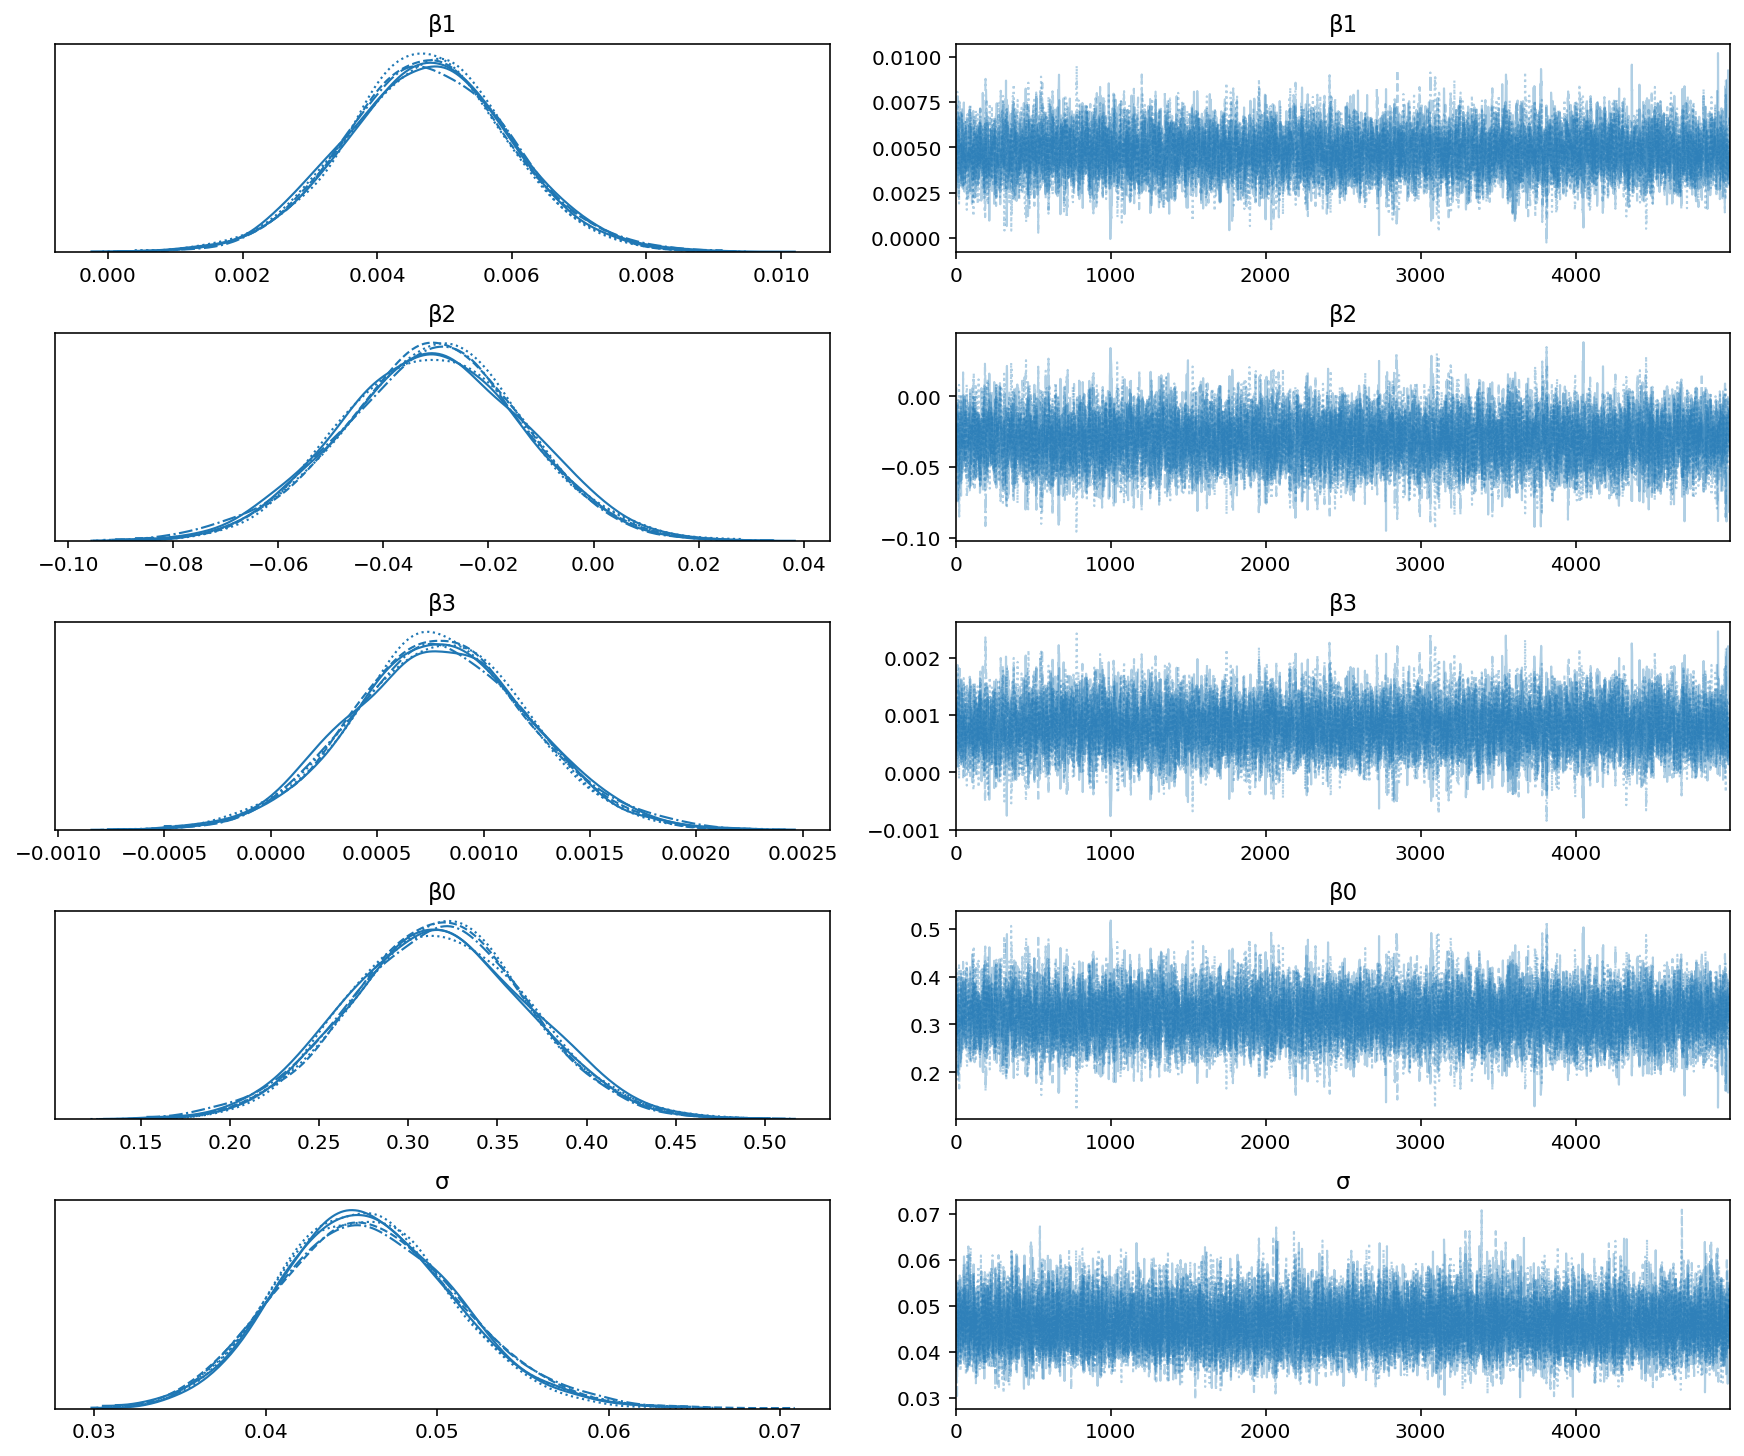

In [11]:
pm.traceplot(trace)

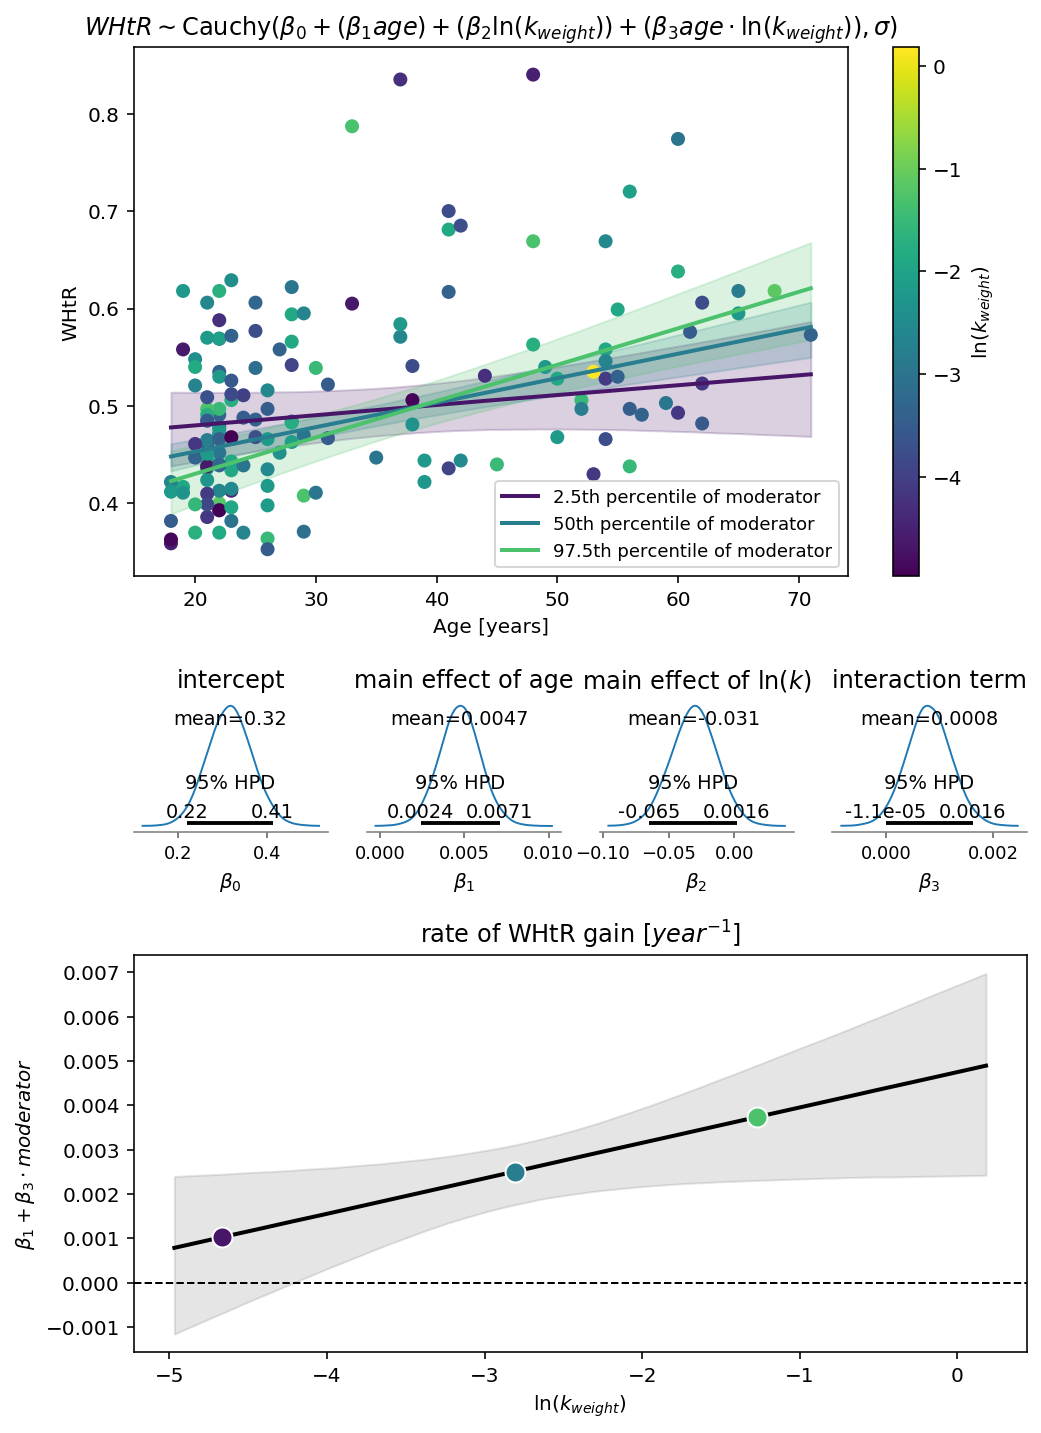

In [12]:
ax1, ax2, axb0, axb1, axb2, axb3 = whtr_age_weight.plot_multipanel(
    figsize=figsize, moderation_multiplier=1
)

# modifications to plot

ax1.set(
    title=r"$WHtR \sim \mathrm{Cauchy}(\beta_0 + (\beta_1 age) + (\beta_2 \ln(k_{weight})) + (\beta_3 age \cdot \ln(k_{weight})), \sigma)$"
)

ax2.set(title="rate of WHtR gain [$year^{-1}$]")

plt.savefig("study2 whtr~age*weight.pdf", bbox_inches="tight")
plt.savefig("study2 whtr~age*weight.png", bbox_inches="tight", dpi=300)

# Discounting of food rewards

## Analysis 3: `BMI ~ age + logk_food + age:logk_food`

In [13]:
bmi_age_food = BayesianModeration(
    y=data.BMI.values,
    x=data.age.values,
    m=data.logk_fcq.values,
    xlabel=r"Age [years]",
    ylabel="BMI [$kg/m^2$]",
    mlabel=r"$\ln(k_{food})$",
    prior=BMI_prior,
    sample_options=sample_options,
)

model = bmi_age_food.model
trace = bmi_age_food.trace

Prior parameters are:
{'β0μ': 12, 'β0σ': 20, 'β1μ': 0, 'β1σ': 20, 'β2μ': 0, 'β2σ': 20, 'β3μ': 0, 'β3σ': 20, 'σ': 1}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [σ, β3, β2, β1, β0]
Sampling 6 chains, 0 divergences: 100%|██████████| 42000/42000 [00:39<00:00, 1054.89draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc8c23ba10>,
      dtype=object)

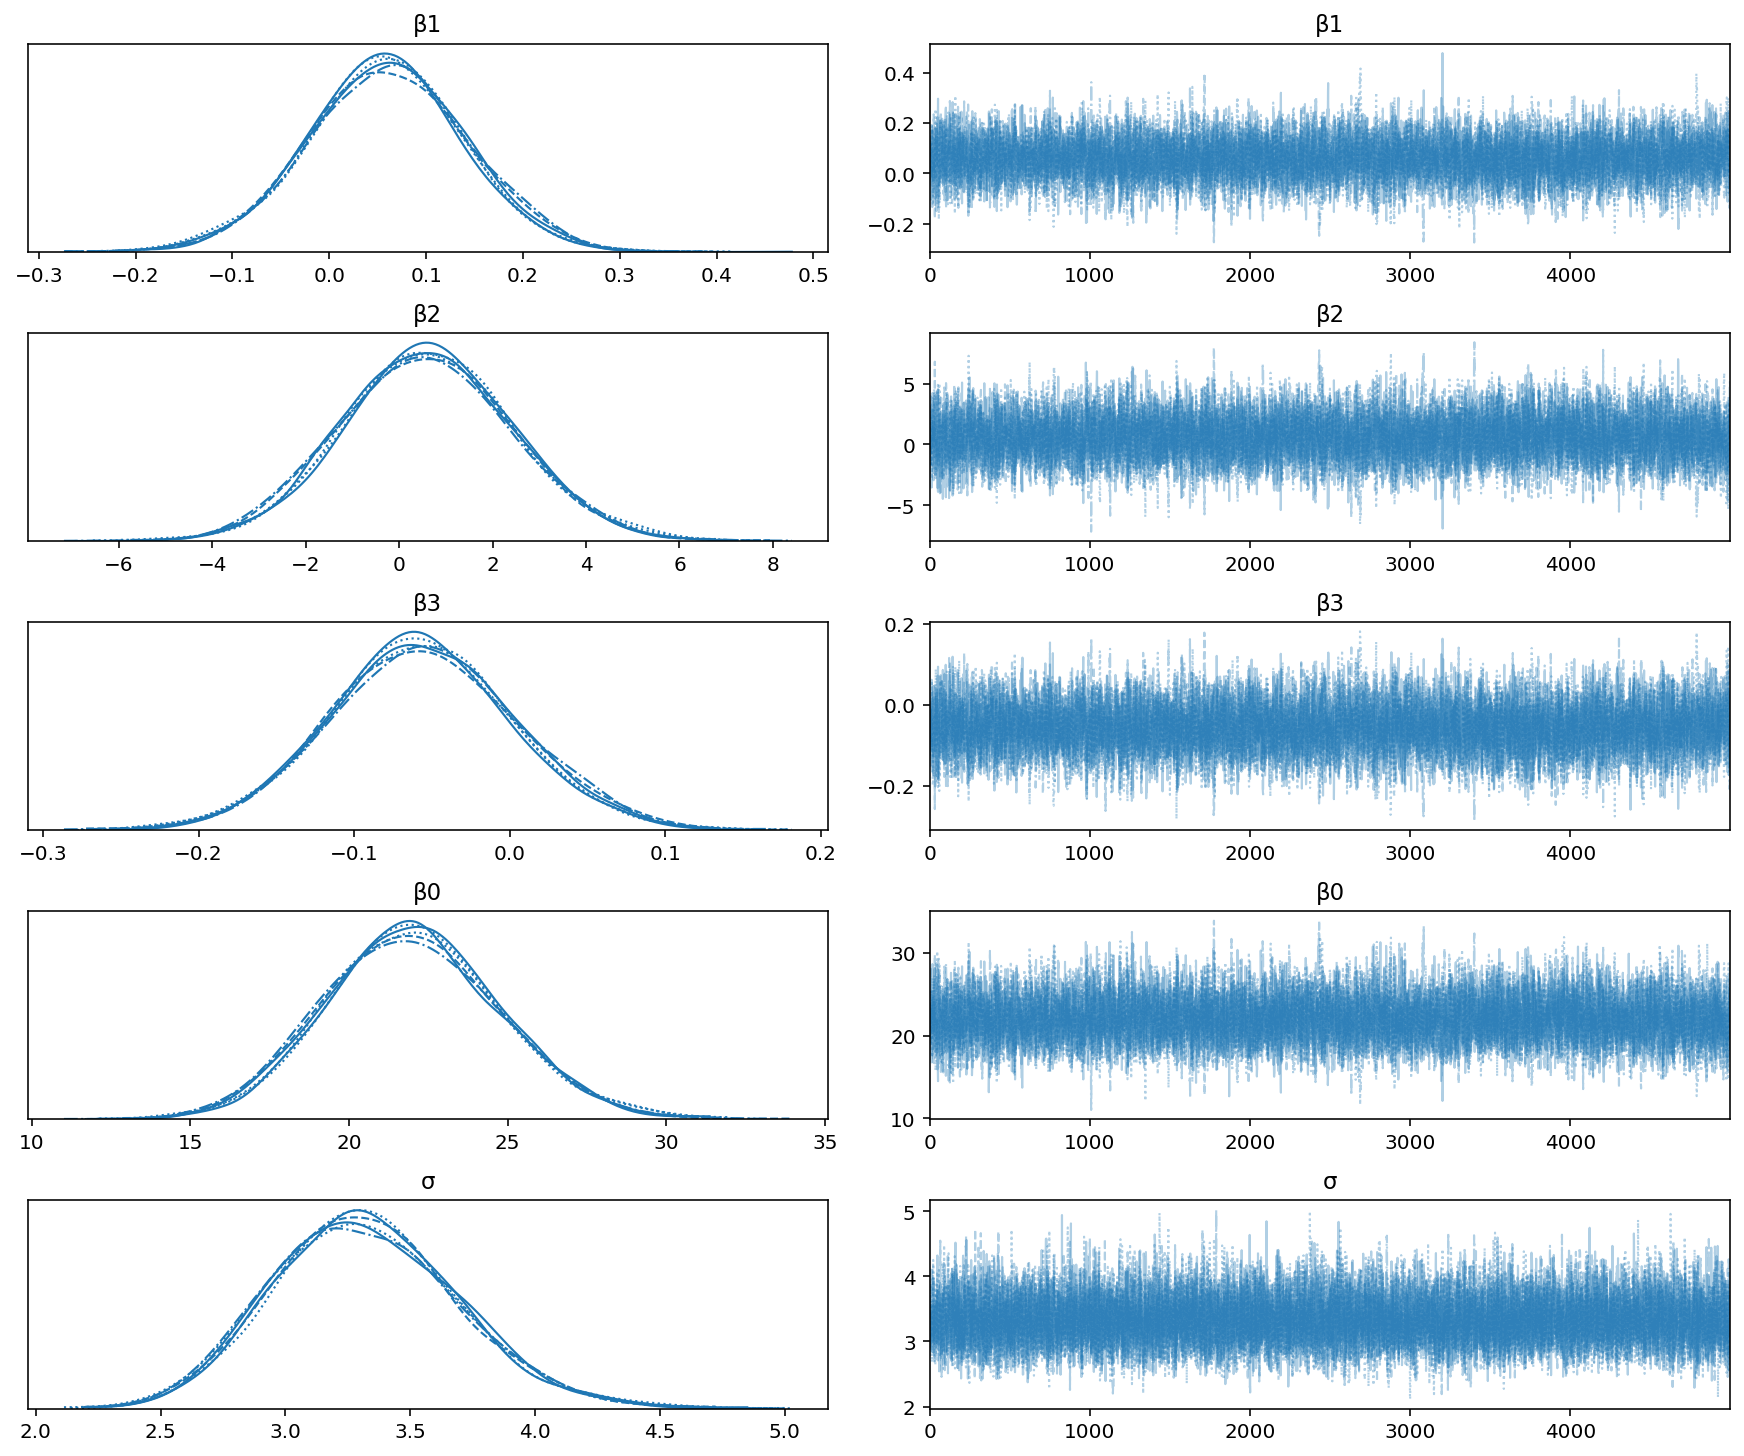

In [14]:
pm.traceplot(trace)

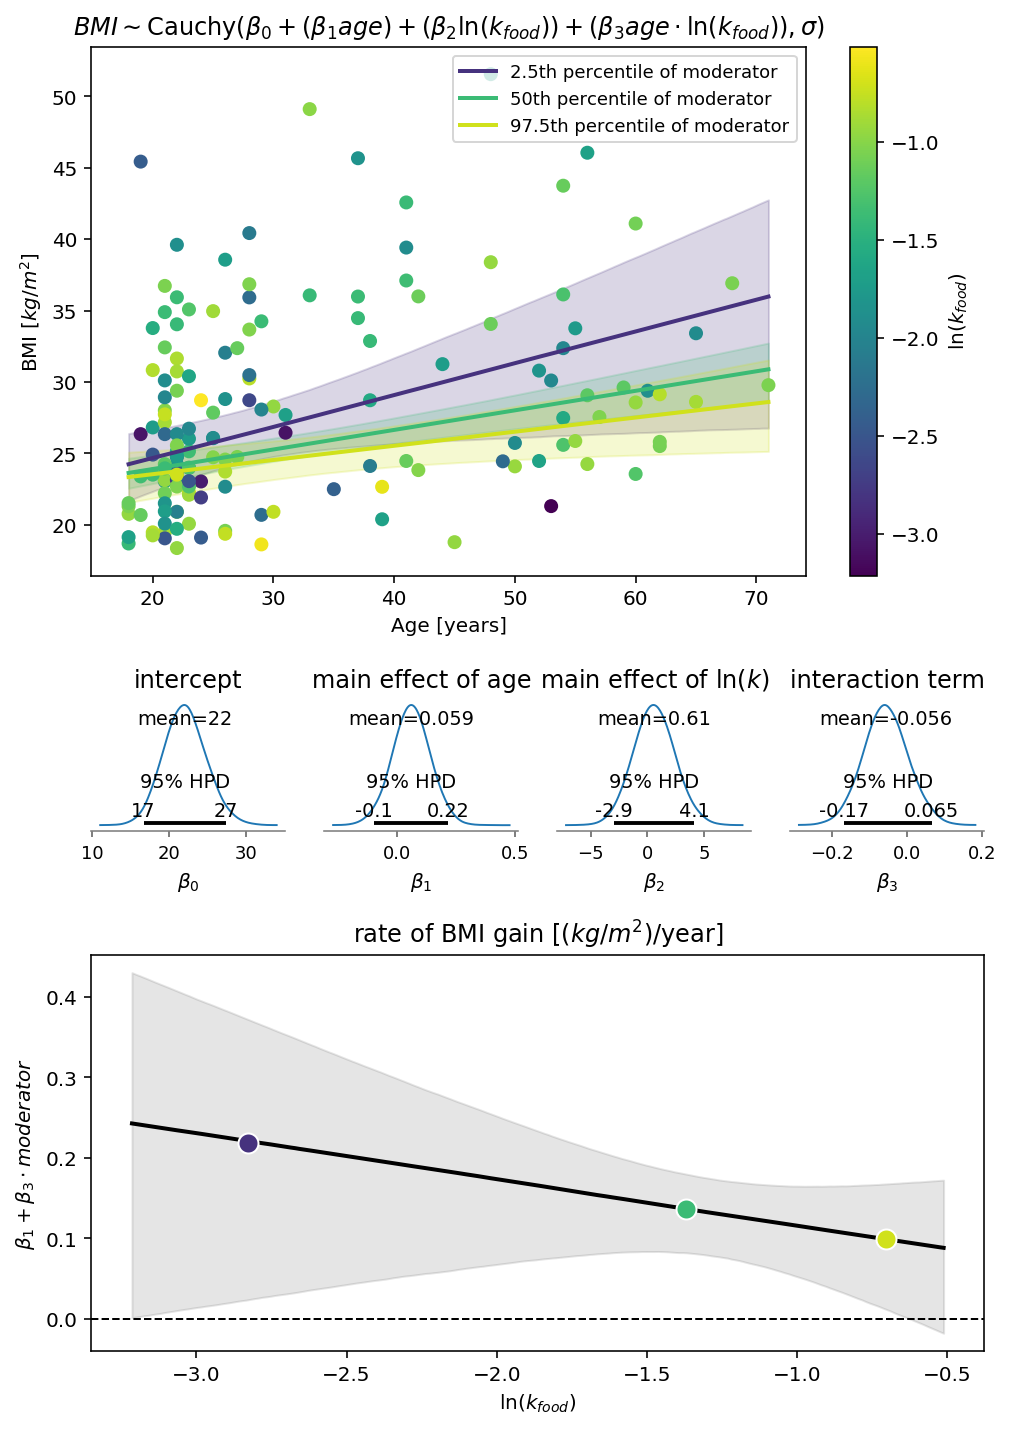

In [15]:
ax1, ax2, axb0, axb1, axb2, axb3 = bmi_age_food.plot_multipanel(
    figsize=figsize, moderation_multiplier=1
)

# modifications to plot

ax1.set(
    title=r"$BMI \sim \mathrm{Cauchy}(\beta_0 + (\beta_1 age) + (\beta_2 \ln(k_{food})) + (\beta_3 age \cdot \ln(k_{food})), \sigma)$"
)

ax2.set(title="rate of BMI gain [$(kg/m^2)$/year]")

plt.savefig("study2 bmi~age*food.pdf", bbox_inches="tight")
plt.savefig("study2 bmi~age*food.png", bbox_inches="tight", dpi=300)

## Analysis 4: `WHtR ~ age + logk_food + age:logk_food`

In [16]:
whtr_age_food = BayesianModeration(
    y=data.WHtR.values,
    x=data.age.values,
    m=data.logk_fcq.values,
    xlabel=r"Age [years]",
    ylabel="WHtR",
    mlabel=r"$\ln(k_{food})$",
    prior=WHtR_prior,
    sample_options=sample_options,
)

model = whtr_age_food.model
trace = whtr_age_food.trace

Prior parameters are:
{'β0μ': 0.5, 'β0σ': 5, 'β1μ': 0, 'β1σ': 20, 'β2μ': 0, 'β2σ': 20, 'β3μ': 0, 'β3σ': 20, 'σ': 1}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [σ, β3, β2, β1, β0]
Sampling 6 chains, 0 divergences: 100%|██████████| 42000/42000 [00:49<00:00, 843.84draws/s] 
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc920e2390>,
      dtype=object)

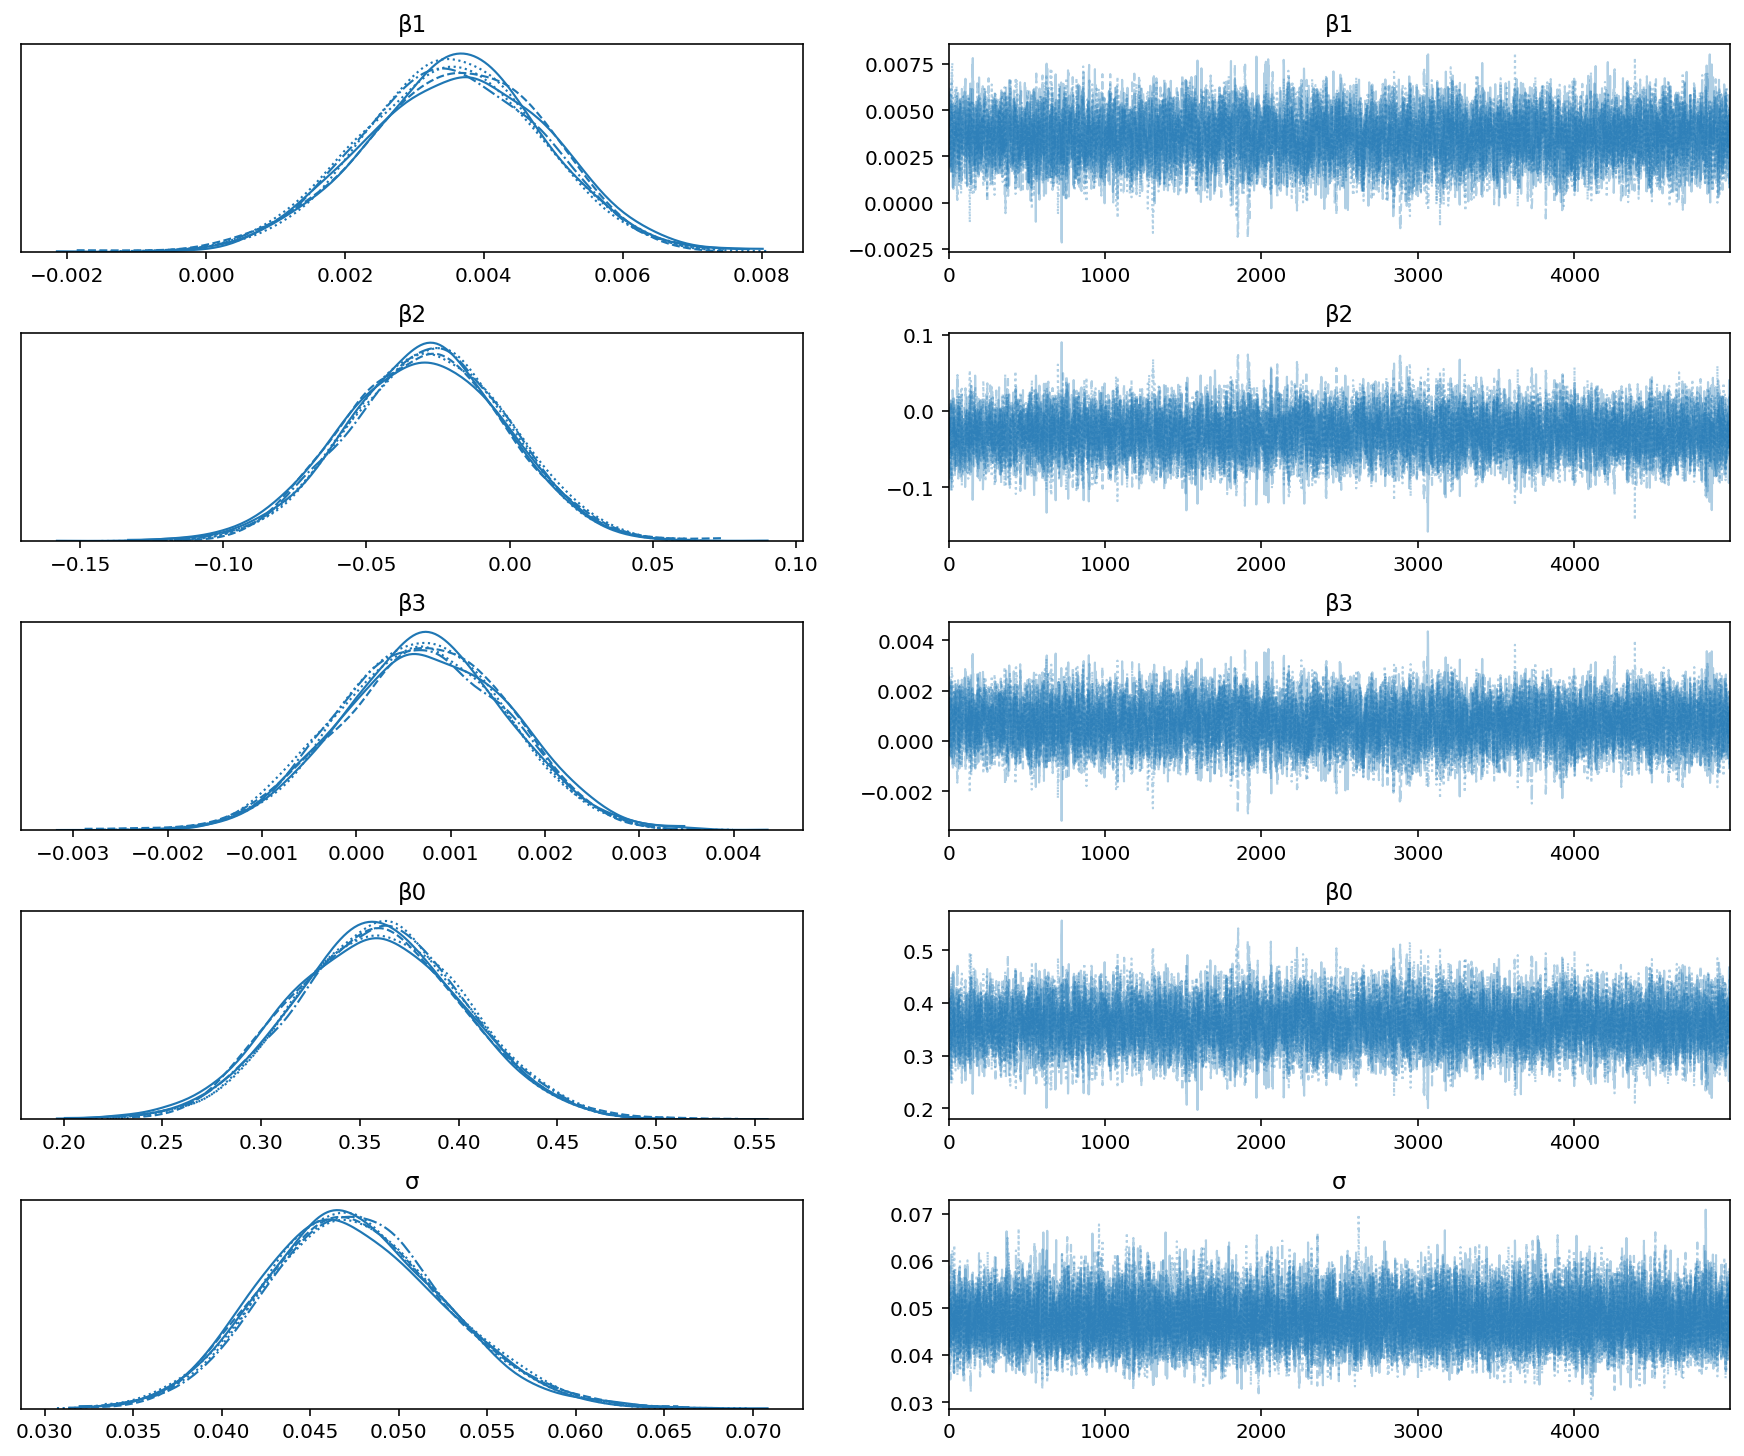

In [17]:
pm.traceplot(trace)

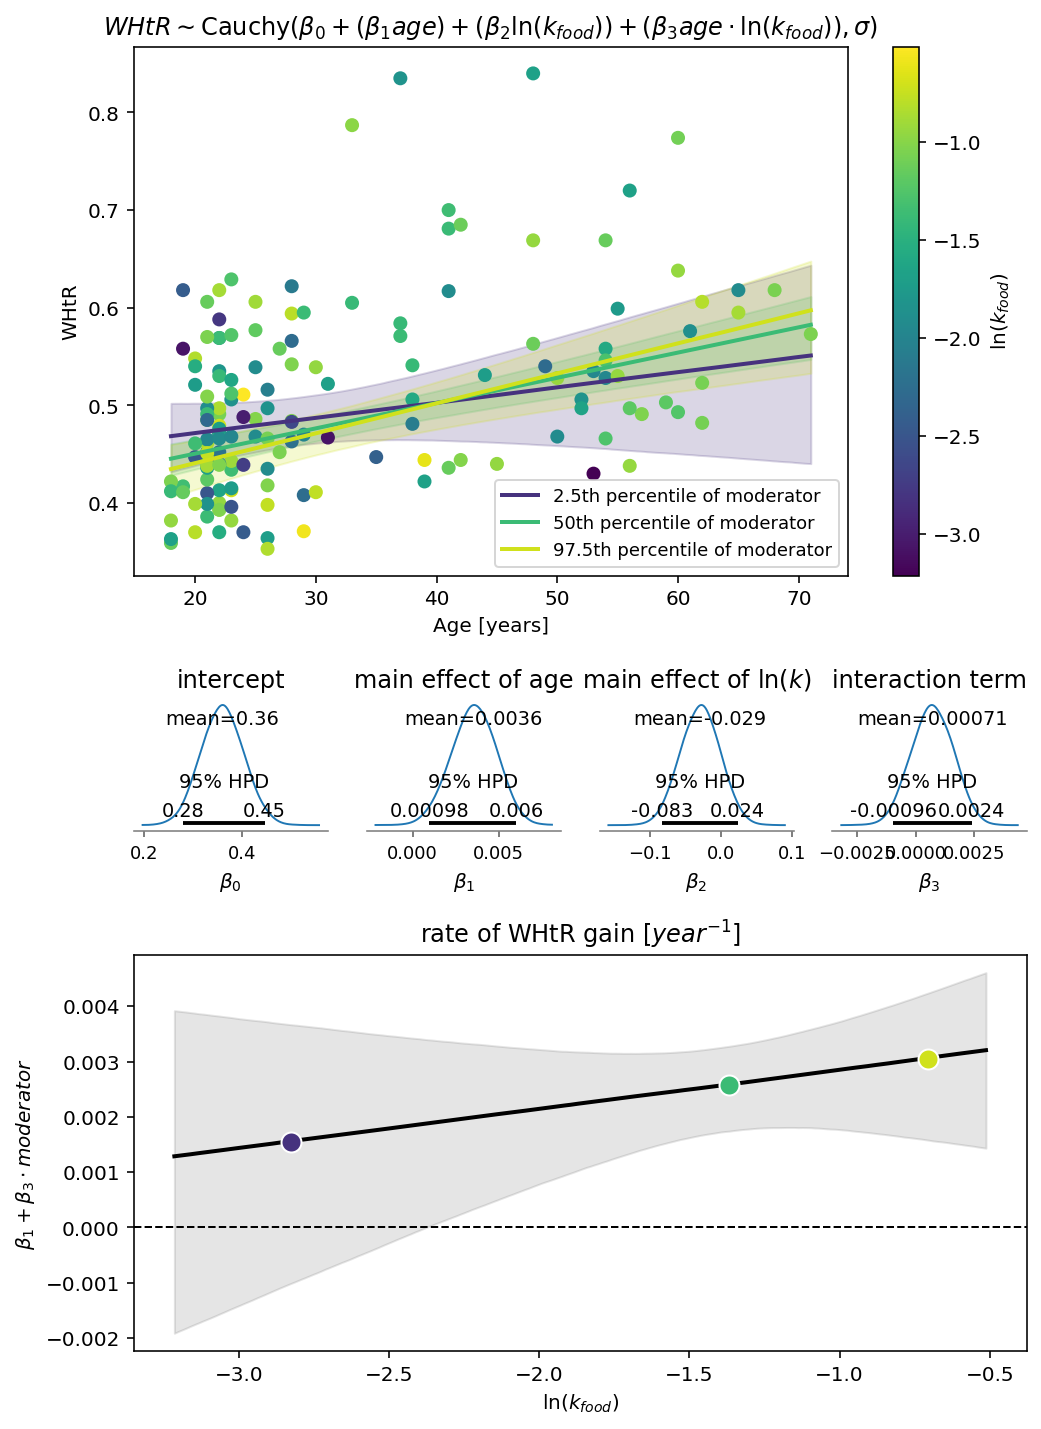

In [18]:
ax1, ax2, axb0, axb1, axb2, axb3 = whtr_age_food.plot_multipanel(
    figsize=figsize, moderation_multiplier=1
)

# modifications to plot

ax1.set(
    title=r"$WHtR \sim \mathrm{Cauchy}(\beta_0 + (\beta_1 age) + (\beta_2 \ln(k_{food})) + (\beta_3 age \cdot \ln(k_{food})), \sigma)$"
)

ax2.set(title="rate of WHtR gain [$year^{-1}$]")

plt.savefig("study2 whtr~age*food.pdf", bbox_inches="tight")
plt.savefig("study2 whtr~age*food.png", bbox_inches="tight", dpi=300)